[2017-09-08 11:41:44,161] Making new env: Pong-v0


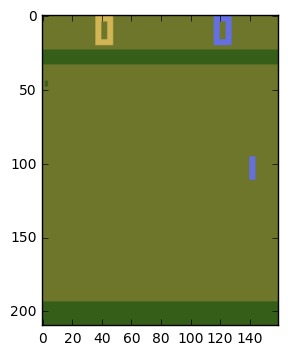

In [1]:
import gym
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

%matplotlib inline
env = gym.make("Pong-v0")
env.reset()
render = lambda: plt.imshow(env.render(mode='rgb_array'))
render()
plt.show()

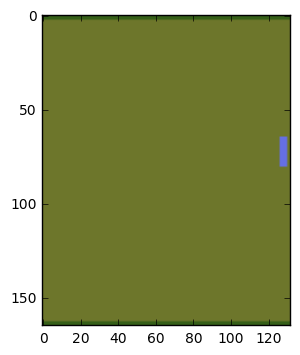

In [2]:
plt.imshow(env.render(mode='rgb_array')[31:196,14:146])

(0.0, False, {'ale.lives': 0})


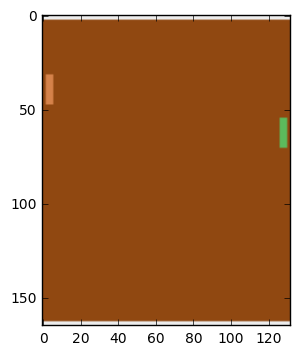

In [9]:
import time

if 0:
    env.reset()
img = plt.imshow(env.render(mode='rgb_array')[31:196,14:146]) # only call this once
for _ in range(21):
    img.set_data(env.render(mode='rgb_array')[31:196,14:146]) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action = env.action_space.sample()
    time.sleep(0.5)
    #the reward element (index 1) is -1 after losing a point, presumably +1 after winning
    print(env.step(action)[1:])
    time.sleep(0.5)

In [3]:
env.reset()
print(env.action_space)
env.unwrapped.get_action_meanings()

Discrete(6)


['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

(0.0, False, {'ale.lives': 0})


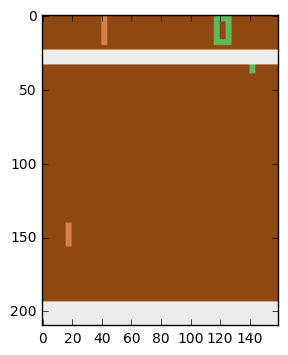

In [40]:
#1 does nothing, 2 goes up, 3 goes down
print(env.step(1)[1:])
render()
plt.show()

In [ ]:
input_dim = (196-31)*(146-14)*3

x = tf.placeholder(tf.float32, shape=[None, input_dim])
y = tf.placeholder(tf.float32, shape=[None, 1])

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

h1_dim = 10
w1 = weight_variable([input_dim, h1_dim])
b1 = bias_variable([h1_dim])
r1 = tf.nn.relu(tf.matmul(x,w1) + b1)
w2 = weight_variable([h1_dim, 1])
b2 = bias_variable([1])
logit = tf.matmul(r1,w2) + b2
move_down_probability = tf.nn.sigmoid(logit)
reward = tf.where(move_down_probability>0.5,
                 y*move_down_probability,
                 -y*move_down_probability)
optimizer = tf.train.AdamOptimizer()
train = optimizer.minimize(-reward)

def play_pong(match=0, reset=1):
    frames = []
    if reset:
        frames.append(env.reset()[31:196,14:146].ravel())
    #play one point
    if not match:
        while True:
            p_down = sess.run(move_down_probability,
                              feed_dict={x: np.array([frames[-1]])})
            #choose an action based on this probability, 3=down, 2=up
            action = np.random.binomial(1, p_down) + 2 
            observation, reward, done, info = env.step(action)
            frames.append(observation[31:196,14:146].ravel())
            if reward:
                break
    #play a whole match
    else:
        pass
    reward = reward * np.array([
                [0.99**k] for k in range(len(frames)-1,-1,-1)])
    return np.array(reward)[20:], frames[20:]

epochs = 25
test = 1

with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(epochs):
        #play Pong with the network, save frames and associated rewards
        reward, frames = play_pong()
        train.run(feed_dict={x: frames, y: reward})
    if test:
        game = np.array(play_pong()[1])
        game = game.reshape((len(game),196-31,146-14,3))
        print(game.shape)
        img = plt.imshow(game[0]) # only call this once
        for i in range(len(game)):
            img.set_data(game[i]) # just update the data
            display.display(plt.gcf())
            display.clear_output(wait=True)

In [39]:

with tf.Session(config=config) as sess:
    print(sess.run(w1[0]))

FailedPreconditionError: Attempting to use uninitialized value Variable_69
	 [[Node: Variable_69/read = Identity[T=DT_FLOAT, _class=["loc:@Variable_69"], _device="/job:localhost/replica:0/task:0/gpu:0"](Variable_69)]]
	 [[Node: strided_slice_1/_1 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_13_strided_slice_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'Variable_69/read', defined at:
  File "/home/bb11t/anaconda3/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/bb11t/anaconda3/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/bb11t/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/bb11t/anaconda3/lib/python3.5/site-packages/traitlets/config/application.py", line 653, in launch_instance
    app.start()
  File "/home/bb11t/anaconda3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/bb11t/anaconda3/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/home/bb11t/anaconda3/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/bb11t/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/bb11t/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/bb11t/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/bb11t/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/bb11t/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/bb11t/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/bb11t/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/bb11t/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/bb11t/anaconda3/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/bb11t/anaconda3/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/bb11t/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/bb11t/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/bb11t/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-37-1afe3871f84d>", line 15, in <module>
    w1 = weight_variable([input_dim, h1_dim])
  File "<ipython-input-37-1afe3871f84d>", line 8, in weight_variable
    return tf.Variable(initial)
  File "/home/bb11t/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 226, in __init__
    expected_shape=expected_shape)
  File "/home/bb11t/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 344, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/home/bb11t/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1490, in identity
    result = _op_def_lib.apply_op("Identity", input=input, name=name)
  File "/home/bb11t/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/home/bb11t/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2395, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/bb11t/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1264, in __init__
    self._traceback = _extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value Variable_69
	 [[Node: Variable_69/read = Identity[T=DT_FLOAT, _class=["loc:@Variable_69"], _device="/job:localhost/replica:0/task:0/gpu:0"](Variable_69)]]
	 [[Node: strided_slice_1/_1 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_13_strided_slice_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [31]:
z=np.ones(1)
z

array([ 5.])

In [18]:
#learn y = x * 0.1 + 0.3
x_data = np.random.rand(100).astype(np.float32)
y_data = (x_data>0.5).astype(np.float32)

# Try to find values for W and b that compute y_data = W * x_data + b
# (We know that W should be 0.1 and b 0.3, but TensorFlow will
# figure that out for us.)
W = tf.Variable(tf.random_uniform([1], -1.0, 1.0))
b = tf.Variable(tf.zeros([1]))
logits = W * x_data + b

# Minimize the mean squared errors.
#loss = tf.reduce_mean(tf.square(y - y_data))
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_data, logits=logits)
optimizer = tf.train.AdamOptimizer(0.5)
train = optimizer.minimize(loss)

# Before starting, initialize the variables.  We will 'run' this first.
init = tf.global_variables_initializer()

# Launch the graph.
sess = tf.Session(config=config)
sess.run(init)

# Fit the line.
for step in range(201):
    sess.run(train)
    if step % 20 == 0:
        print(step, sess.run(W), sess.run(b))

# Learns best fit is W: [0.1], b: [0.3]

0 [ 1.28379107] [-0.49999991]
20 [ 9.57364464] [-4.72542286]
40 [ 13.95759296] [-6.84228659]
60 [ 16.55422211] [-8.05457211]
80 [ 18.52279472] [-8.99449253]
100 [ 20.2229538] [-9.79433537]
120 [ 21.76064301] [-10.51799488]
140 [ 23.17978477] [-11.18589306]
160 [ 24.50509071] [-11.80889702]
180 [ 25.75300598] [-12.39570045]
200 [ 26.93569946] [-12.95180702]


In [ ]:
sess = tf.InteractiveSession()

# Create 100 phony x, y data points in NumPy, y = x * 0.1 + 0.3
np.random.seed(1)
x_data = np.random.rand(1).astype("float32")
y_data = (x_data < 0.5).astype("float32")

x = tf.placeholder(tf.float32, shape=[None, 1])
y_ = tf.placeholder(tf.float32, shape=[None, 1])


# Try to find values for W and b that compute y_data = W * x_data + b
# (We know that W should be 0.1 and b 0.3, but Tensorflow will
# figure that out for us.)
W = tf.Variable(tf.random_uniform([1], -1.0, 1.0, seed=1))
b = tf.Variable(tf.zeros([1]))
logits = W * x_data + b


solo_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
                        labels=y_data, logits=logits)
cross_entropy = tf.reduce_mean(solo_cross_entropy)
optimizer = tf.train.GradientDescentOptimizer(0.5)
train = optimizer.minimize(cross_entropy)

tf.global_variables_initializer().run()

# Fit the line.
for step in range(10):
    print (step, sess.run(W), sess.run(b), sess.run(logits),
           sess.run(solo_cross_entropy) )
    sess.run(train)


In [250]:
y_data

array([ 1.], dtype=float32)

In [75]:
sess.run(tf.nn.softmax([-1.]))

array([ 1.], dtype=float32)